# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
from torchvision import datasets

# Define transforms
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

# Create training set and define training dataloader
trainset = datasets.CIFAR10(root='./data', download=True, train=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data', download=True, train=False, transform=test_transform)

# Splitting the data between train, validation and test set
length_pre_training_dataset = len(trainset)
training_dataset_size = int(0.8 * length_pre_training_dataset)
validation_dataset_size = length_pre_training_dataset - training_dataset_size

training_dataset, validation_dataset = torch.utils.data.random_split(trainset, [training_dataset_size, validation_dataset_size])

# Create test set and define test dataloader
trainloader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])
torch.Size([64])


In [5]:
dataiter = iter(validationloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])
torch.Size([64])


In [6]:
dataiter = iter(testloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])
torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


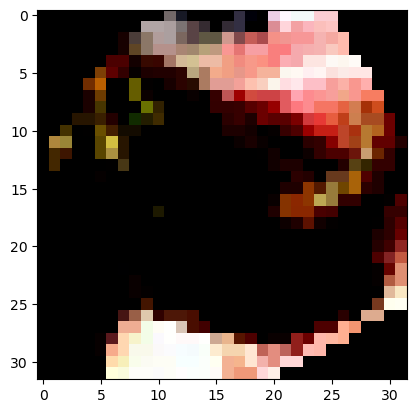

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


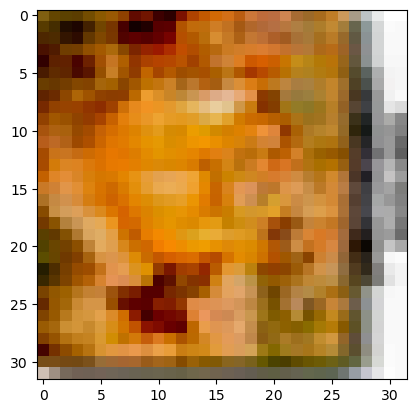

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


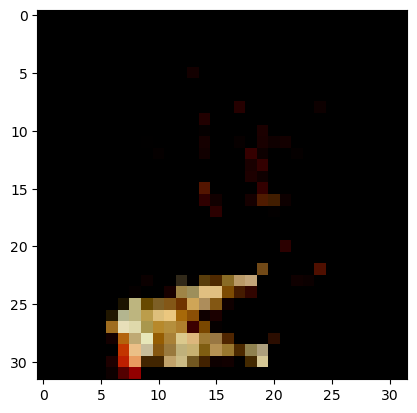

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


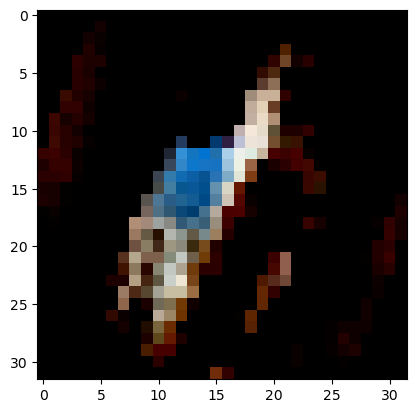

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bird


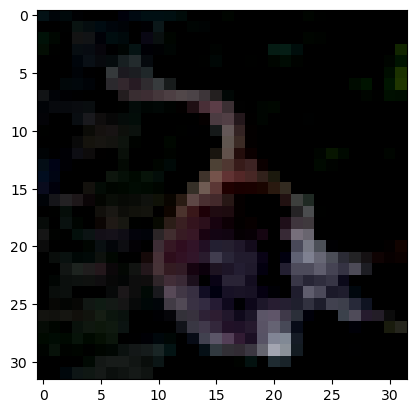

In [7]:
# Explore data
show5(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


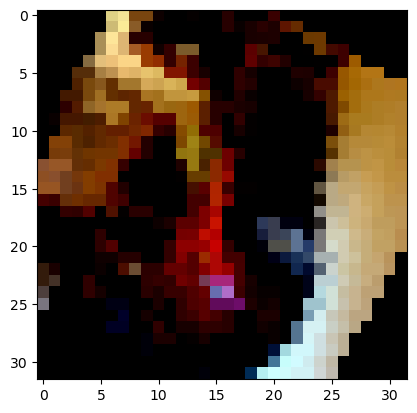

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


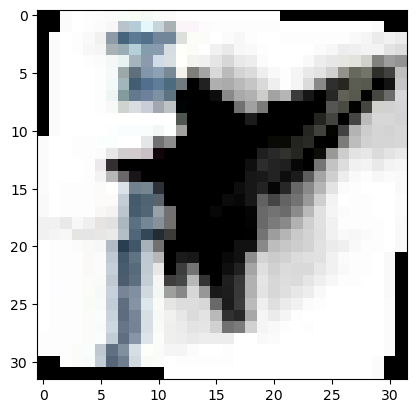

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


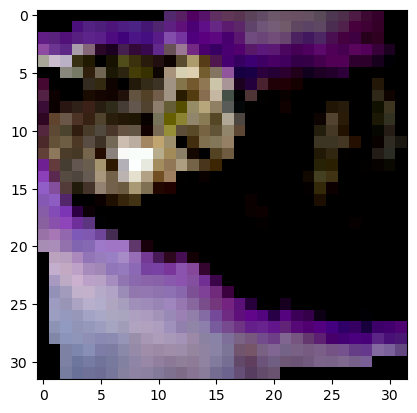

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


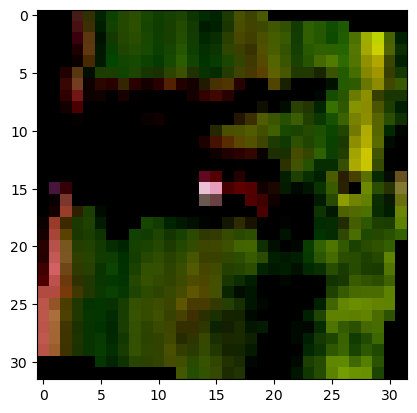

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


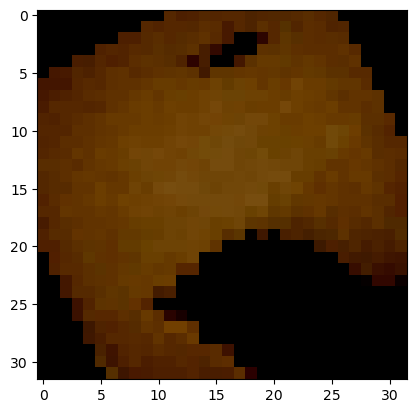

In [8]:
show5(validationloader)

dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


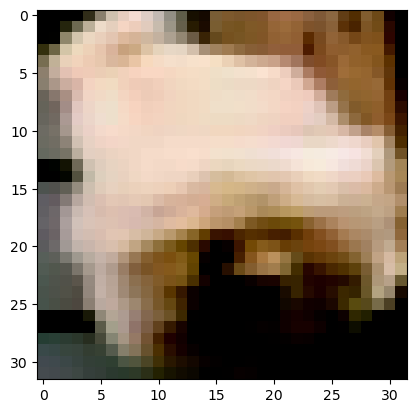

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


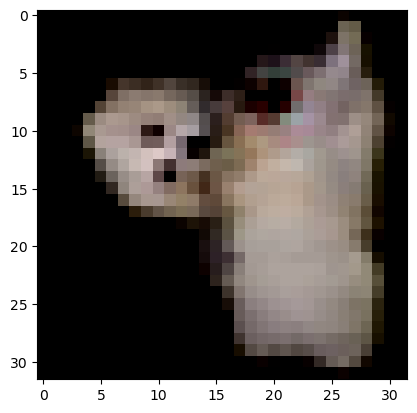

horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


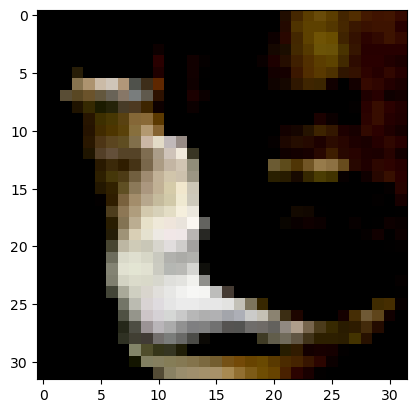

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


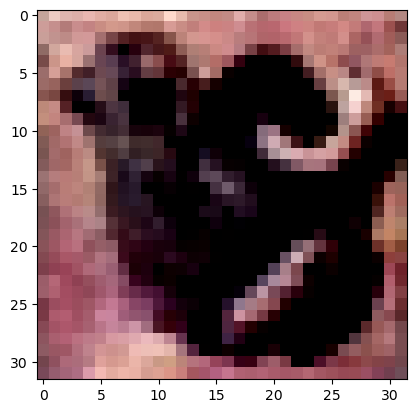

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


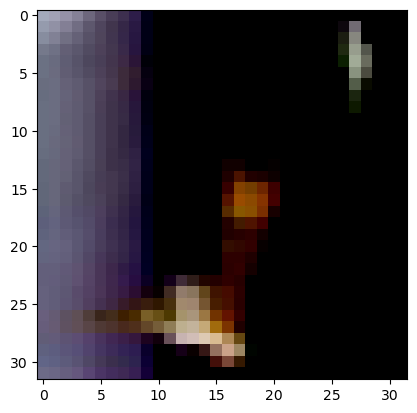

In [9]:
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [10]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 1098)
        self.fc2 = nn.Linear(1098, 972)
        self.fc3 = nn.Linear(972, 675)
        self.fc4 = nn.Linear(675, 64)
        self.fc5 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0],-1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [11]:
## YOUR CODE HERE ##
model = Network()
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.003)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [12]:
## YOUR CODE HERE ##
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 100
steps = 0
running_loss = 0
print_every = 250
train_losses, validation_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps+=1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            validation_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validationloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model(inputs)
                    validation_loss += criterion(logps, labels)
                    
                    #Calculando la precisión
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            train_losses.append(running_loss/len(trainloader))
            validation_losses.append(validation_loss/len(validationloader))
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {validation_loss/len(validationloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validationloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/100.. Train loss: 2.303.. Validation loss: 2.300.. Validation accuracy: 0.140
Epoch 1/100.. Train loss: 2.295.. Validation loss: 2.286.. Validation accuracy: 0.194
Epoch 2/100.. Train loss: 2.274.. Validation loss: 2.251.. Validation accuracy: 0.176
Epoch 2/100.. Train loss: 2.229.. Validation loss: 2.189.. Validation accuracy: 0.192
Epoch 2/100.. Train loss: 2.160.. Validation loss: 2.099.. Validation accuracy: 0.235
Epoch 3/100.. Train loss: 2.079.. Validation loss: 2.027.. Validation accuracy: 0.269
Epoch 3/100.. Train loss: 2.035.. Validation loss: 1.992.. Validation accuracy: 0.275
Epoch 4/100.. Train loss: 1.998.. Validation loss: 1.956.. Validation accuracy: 0.280
Epoch 4/100.. Train loss: 1.967.. Validation loss: 1.924.. Validation accuracy: 0.299
Epoch 4/100.. Train loss: 1.926.. Validation loss: 1.896.. Validation accuracy: 0.309
Epoch 5/100.. Train loss: 1.901.. Validation loss: 1.863.. Validation accuracy: 0.328
Epoch 5/100.. Train loss: 1.879.. Validation loss: 1.8

Epoch 39/100.. Train loss: 1.331.. Validation loss: 1.327.. Validation accuracy: 0.528
Epoch 39/100.. Train loss: 1.322.. Validation loss: 1.325.. Validation accuracy: 0.527
Epoch 40/100.. Train loss: 1.334.. Validation loss: 1.322.. Validation accuracy: 0.527
Epoch 40/100.. Train loss: 1.331.. Validation loss: 1.326.. Validation accuracy: 0.529
Epoch 40/100.. Train loss: 1.333.. Validation loss: 1.318.. Validation accuracy: 0.526
Epoch 41/100.. Train loss: 1.323.. Validation loss: 1.322.. Validation accuracy: 0.529
Epoch 41/100.. Train loss: 1.314.. Validation loss: 1.319.. Validation accuracy: 0.527
Epoch 42/100.. Train loss: 1.317.. Validation loss: 1.315.. Validation accuracy: 0.528
Epoch 42/100.. Train loss: 1.316.. Validation loss: 1.304.. Validation accuracy: 0.540
Epoch 42/100.. Train loss: 1.322.. Validation loss: 1.318.. Validation accuracy: 0.530
Epoch 43/100.. Train loss: 1.296.. Validation loss: 1.312.. Validation accuracy: 0.530
Epoch 43/100.. Train loss: 1.322.. Validati

Epoch 77/100.. Train loss: 1.141.. Validation loss: 1.219.. Validation accuracy: 0.566
Epoch 77/100.. Train loss: 1.150.. Validation loss: 1.206.. Validation accuracy: 0.571
Epoch 78/100.. Train loss: 1.156.. Validation loss: 1.216.. Validation accuracy: 0.566
Epoch 78/100.. Train loss: 1.149.. Validation loss: 1.215.. Validation accuracy: 0.568
Epoch 78/100.. Train loss: 1.150.. Validation loss: 1.206.. Validation accuracy: 0.570
Epoch 79/100.. Train loss: 1.132.. Validation loss: 1.208.. Validation accuracy: 0.572
Epoch 79/100.. Train loss: 1.153.. Validation loss: 1.203.. Validation accuracy: 0.570
Epoch 80/100.. Train loss: 1.138.. Validation loss: 1.216.. Validation accuracy: 0.575
Epoch 80/100.. Train loss: 1.138.. Validation loss: 1.208.. Validation accuracy: 0.573
Epoch 80/100.. Train loss: 1.148.. Validation loss: 1.212.. Validation accuracy: 0.572
Epoch 81/100.. Train loss: 1.137.. Validation loss: 1.208.. Validation accuracy: 0.574
Epoch 81/100.. Train loss: 1.145.. Validati

Plot the training loss (and validation loss/accuracy, if recorded).

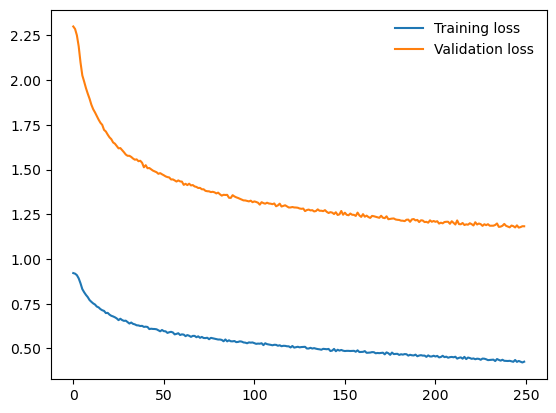

In [15]:
## YOUR CODE HERE ##
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [16]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on 10000 test images is: {100 * correct // total} %')

Accuracy of the network on 10000 test images is: 54 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [17]:
## YOUR CODE HERE ##
PATH = 'C:\\Users\\B36510\\Documents\\Clases\\Udacity\\Intro to Machine Learning with Pytorch\\Project 2\\cifar-10-image-classifier-starter\\prueba1.pth'
torch.save(model.state_dict(), PATH)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

**Answer**
My model came out with a lower accuracy than the Detectocorp model, I have worked with 5 layers and changing the loss function for the CrossEntropyLoss and the SGD optimization function. I consider that I could load other already trained models to increase the accuracy. As a final answer, I would recommend purchasing the Detectocorp model.